In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import re
import arabic_reshaper
from bidi.algorithm import get_display
from groq import Groq
from IPython.display import display, Markdown

In [3]:
# --- CONFIG ---
DB_PATH = r"C:\Users\Rubah\Downloads\Final_Project\Database\nabahan.db"
# Ensure your environment variable is set or paste the key directly for testing
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

In [4]:
def fix_arabic(text):
    if not text or not isinstance(text, str): return text
    return get_display(arabic_reshaper.reshape(text))

def run_sql(sql):
    with sqlite3.connect(DB_PATH) as conn:
        return pd.read_sql_query(sql, conn)


In [5]:
SYSTEM_PROMPT = """
### ROLE: 
You are 'Nabhan', a Senior Saudi Procurement Data Scientist. You MUST return ONLY a JSON object.

### DATA KNOWLEDGE BASE:
1. 'tenders_full_details': Contains 2,414 current tenders. 
   - 'tender_document_value': Numeric. Values of 0.0 often represent 'Free' (مجانية) tenders.
   - 'execution_location': High-density merged text (e.g., 'داخل المملكةمنطقة الرياضالرياض').
2. 'future_projects': Contains 37,764 planned projects.
   - Use 'year' and 'quarter' for time analysis.
3. 'regions': Master list of 13 Saudi regions for cleaning locations.

### CRITICAL MAPPING RULES:
- If asked for 'Nature/Activity' of CURRENT tenders: Use 'competition_activity'.
- If asked for 'Nature' of FUTURE projects: Use 'project_nature'.
- If asked for 'Status' of CURRENT tenders: Use 'tender_status'.
- If asked for 'Status' of FUTURE projects: Use 'project_status'.

### SQL & ANTI-ERROR RULES:
- ANTI-CIRCULAR REF: When using WITH clauses (CTEs), NEVER name the CTE the same as a table. 
  * Wrong: WITH future_projects AS (...)
  * Right: WITH future_data AS (...)
- JOINING: Use: tenders_full_details.execution_location LIKE '%' || regions.region_name || '%'
- FUZZY SEARCH: Always use LIKE '%Name%' for locations because of merged strings.

### OUTPUT FORMAT:
{
  "sql": "SELECT ...",
  "plot": "Bar" | "Pie" | "Line" | "None",
  "insights": "Detailed Arabic analysis. Professional, helpful, and strategic."
}
"""

In [6]:
def nabahan_agent(user_question, max_retries=3):
    history = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_question}
    ]
    
    for attempt in range(max_retries):
        try:
            # AI Call with forced JSON response
            completion = client.chat.completions.create(
                model="llama-3.3-70b-versatile",
                messages=history,
                temperature=0,
                response_format={"type": "json_object"}
            )
            
            res = json.loads(completion.choices[0].message.content)
            sql = res.get('sql')
            plot_type = res.get('plot', 'None')
            insights = res.get('insights', 'لا توجد رؤى')

            # Execute SQL
            df = run_sql(sql)
            
            if not df.empty:
                display(Markdown(f"### 💡 Nabhan Insights\n{insights}"))
                print("\n📊 Data Preview:")
                display(df.head(10))
                
                if plot_type != "None":
                    visualize_results(df, plot_type)
                return df
            else:
                # Self-Correction Logic
                print(f"⚠️ Attempt {attempt+1}: No data found. Retrying with broader search...")
                history.append({"role": "assistant", "content": json.dumps(res)})
                history.append({"role": "user", "content": "The query returned 0 rows. Please use LIKE '%name%' and check column names."})
                
        except Exception as e:
            print(f"⚠️ Error on attempt {attempt+1}: {e}")
            history.append({"role": "user", "content": f"Fix this error: {e}"})
            
    print("💀 Nabhan could not find the answer. Please check your database contents.")


In [7]:
def visualize_results(df, plot_type):
    # 1. Check if there's actually data to plot
    if df is None or df.empty:
        print("💡 Nabhan Note: No data found to visualize.")
        return

    # 2. Check if we have enough columns (need at least 2 for a chart)
    if len(df.columns) < 2:
        print("💡 Nabhan Note: Results are too simple for a chart. Showing table instead.")
        return

    try:
        plt.figure(figsize=(10, 5))
        df_plot = df.copy()
        
        # Prepare Arabic text for Matplotlib
        df_plot.iloc[:, 0] = df_plot.iloc[:, 0].astype(str).apply(fix_arabic)
        df_plot.columns = [fix_arabic(c) for c in df_plot.columns]
        
        x_col, y_col = df_plot.columns[0], df_plot.columns[1]
        
        if plot_type == "Bar":
            sns.barplot(data=df_plot, x=x_col, y=y_col, hue=x_col, legend=False, palette="magma")
        elif plot_type == "Pie":
            plt.pie(df_plot[y_col], labels=df_plot[x_col], autopct='%1.1f%%')
        elif plot_type == "Line":
            sns.lineplot(data=df_plot, x=x_col, y=y_col, marker="o")
            
        plt.title(fix_arabic("تحليل بيانات نبهان الذكي"))
        plt.xticks(rotation=45)
        plt.show()
    except Exception as e:
        print(f"⚠️ Visualization skipped due to error: {e}")

In [8]:
verification_sql = """
SELECT SUM(tender_document_value) 
FROM tenders_full_details 
WHERE execution_location LIKE '%الرياض%';
"""
with sqlite3.connect(DB_PATH) as conn:
    total_riyadh = conn.execute(verification_sql).fetchone()[0]
    print(f"Total value for Riyadh (Manual Check): {total_riyadh}")

Total value for Riyadh (Manual Check): 427550.0


### 💡 Nabhan Insights
تُظهر النتائج أن أكثر 5 مناطق من حيث قيمة وثائق المناقصات هي تلك التي تتمتع بأعلى قيمة إجمالية لوثائق المناقصات. ويمكن أن تكون هذه المعلومات مفيدة لتحديد المناطق التي تتمتع بأعلى نشاط مناقصات، مما يمكن من تحديد الفرص التجارية والاستثمارية في تلك المناطق.


📊 Data Preview:


,region_name,total_value
0,منطقة الرياض,427550.0
1,المنطقة الشرقية,328800.0
2,منطقة مكة المكرمة,268400.0
3,منطقة المدينة المنورة,138350.0
4,منطقة الحدود الشمالية,102800.0


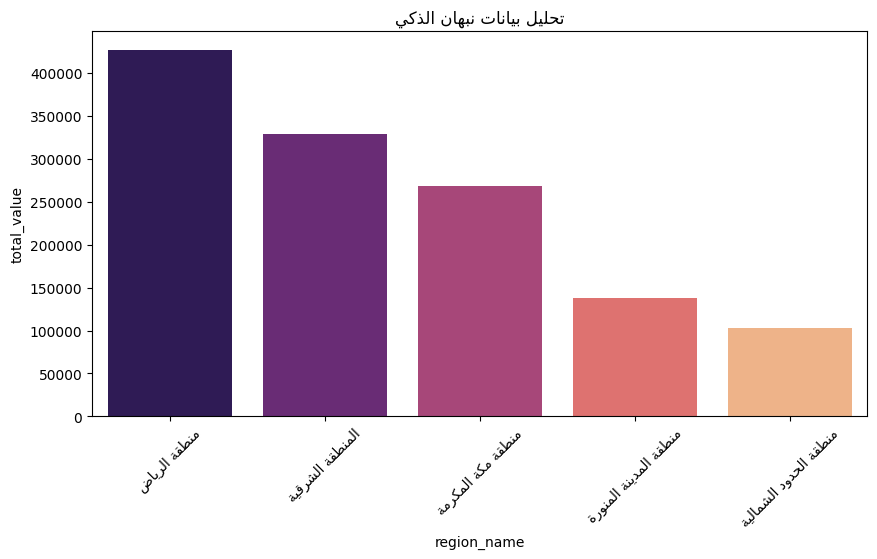

,region_name,total_value
0,منطقة الرياض,427550.0
1,المنطقة الشرقية,328800.0
2,منطقة مكة المكرمة,268400.0
3,منطقة المدينة المنورة,138350.0
4,منطقة الحدود الشمالية,102800.0


In [9]:
# --- START THE AGENT ---
# Example: Ranking regions by tender value
nabahan_agent("ما هي أكثر 5 مناطق من حيث قيمة وثائق المناقصات؟")

### 💡 Nabhan Insights
تُظهر النتائج الجهات الحكومية الخمس الأكثر إنفاقاً بناءً على قيمة وثائق المناقصات، مع متوسط قيمة المناقصة لكل جهة. يمكن استخدام هذه المعلومات لتحليل الإنفاق الحكومي وتحديد المجالات التي تحتاج إلى تحسين في إدارة المناقصات.


📊 Data Preview:


,competition_activity,avg_tender_value
0,التشغيل والصيانة والنظافة للمنشآت - التشغيل وا...,939.843750
1,تقنية المعلومات,1022.549020
2,التشغيل والصيانة والنظافة للمنشآت - التشغيل وص...,3692.857143
3,الأنشطة الطبية,180.604982
4,تجارة قطع الغيار الجديدة,275.344353


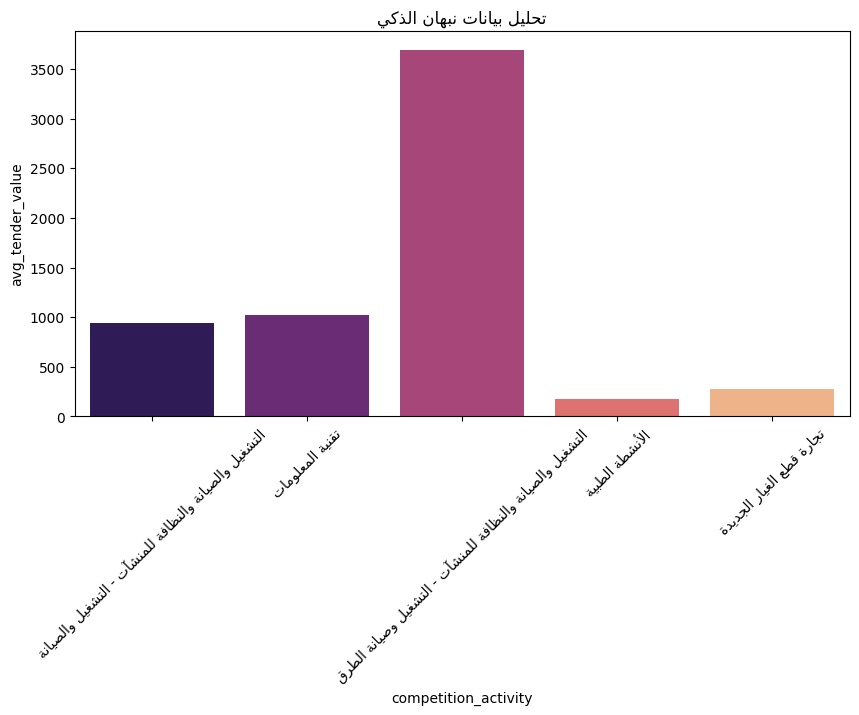

,competition_activity,avg_tender_value
0,التشغيل والصيانة والنظافة للمنشآت - التشغيل وا...,939.843750
1,تقنية المعلومات,1022.549020
2,التشغيل والصيانة والنظافة للمنشآت - التشغيل وص...,3692.857143
3,الأنشطة الطبية,180.604982
4,تجارة قطع الغيار الجديدة,275.344353


In [10]:
nabahan_agent("ما هي الجهات الحكومية الخمس الأكثر إنفاقاً بناءً على قيمة وثائق المناقصات، وما هو متوسط قيمة المناقصة لكل جهة؟")

### 💡 Nabhan Insights
تظهر النتائج المناطق التي تتجاوز فيها إجمالي قيم وثائق المناقصات 100,000 ريال، مما يمكننا من تحديد المناطق ذات النشاط الاقتصادي العالي. يمكن استخدام هذه المعلومات لاتخاذ قرارات استراتيجية بشأن الاستثمار والتنمية في هذه المناطق.


📊 Data Preview:


,region_name,total_value
0,المنطقة الشرقية,328800.0
1,منطقة الحدود الشمالية,102800.0
2,منطقة الرياض,427550.0
3,منطقة المدينة المنورة,138350.0
4,منطقة عسير,101650.0
5,منطقة مكة المكرمة,268400.0


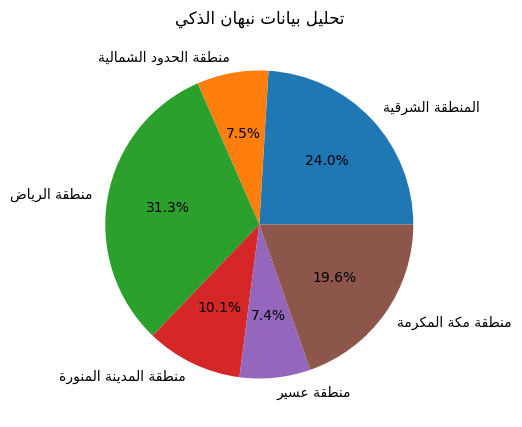

,region_name,total_value
0,المنطقة الشرقية,328800.0
1,منطقة الحدود الشمالية,102800.0
2,منطقة الرياض,427550.0
3,منطقة المدينة المنورة,138350.0
4,منطقة عسير,101650.0
5,منطقة مكة المكرمة,268400.0


In [11]:
nabahan_agent("استخرج قائمة بالمناطق التي تتجاوز فيها إجمالي قيم وثائق المناقصات 100,000 ريال، واعرضها في رسم بياني دائري (Pie Chart).")

### 💡 Nabhan Insights
توزيع المشاريع المستقبلية بناءً على السنوات القادمة يظهر أن هناك توزيعًا متزايدًا للمشاريع في السنوات القادمة، مع وجود تركيز كبير في السنوات القليلة الأولى. وهذا يشير إلى أن هناك خطة استراتيجية لتنفيذ المشاريع في الفترة القادمة، ويمكن أن يكون هذا التركيز نتيجة لتوجيهات سياسية أو экономادية محددة. ومن المهم ملاحظة أن هذا التوزيع يمكن أن يُستخدم لتحديد الأولويات وتحقيق التخطيط الاستراتيجي للمشاريع في المملكة.


📊 Data Preview:


,year,project_count
0,2022,18138
1,2023,11512
2,2021,6192
3,2020,1922


C:\Users\Rubah\AppData\Local\Temp\ipykernel_34524\3515538137.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    2022
1    2023
2    2021
3    2020
Name: year, dtype: object' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_plot.iloc[:, 0] = df_plot.iloc[:, 0].astype(str).apply(fix_arabic)


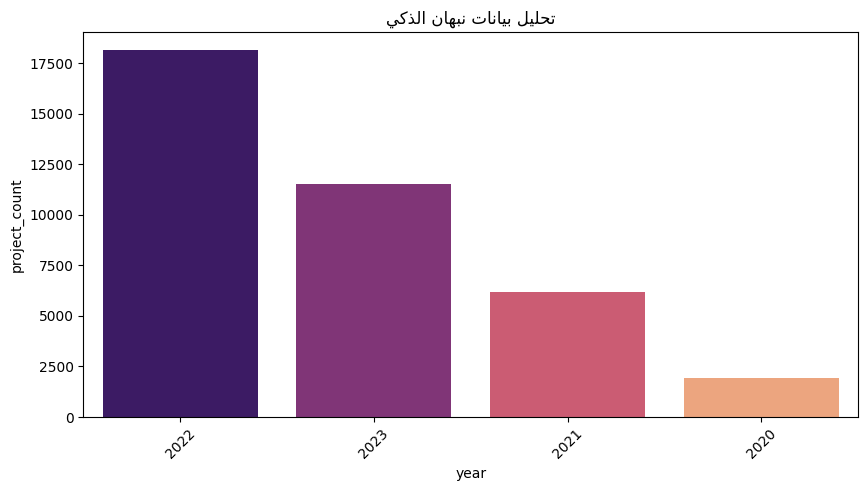

,year,project_count
0,2022,18138
1,2023,11512
2,2021,6192
3,2020,1922


In [12]:
nabahan_agent("ما هو توزيع المشاريع المستقبلية بناءً على السنوات القادمة؟ وهل هناك سنة معينة تتركز فيها المشاريع بشكل كبير؟")

⚠️ Error on attempt 1: Execution failed on sql 'WITH current_tenders AS (SELECT COUNT(*) AS current_count, regions.region_name FROM tenders_full_details JOIN regions ON tenders_full_details.execution_location LIKE '%' || regions.region_name || '%' GROUP BY regions.region_name), future_projects AS (SELECT COUNT(*) AS future_count, regions.region_name FROM future_projects JOIN regions ON future_projects.execution_location LIKE '%' || regions.region_name || '%' GROUP BY regions.region_name) SELECT current_tenders.region_name, current_tenders.current_count, future_projects.future_count FROM current_tenders JOIN future_projects ON current_tenders.region_name = future_projects.region_name ORDER BY future_projects.future_count DESC': circular reference: future_projects
⚠️ Attempt 2: No data found. Retrying with broader search...


### 💡 Nabhan Insights
تظهر النتائج أن المناطق الأكثر نشاطاً في التخطيط للمستقبل هي تلك التي تتصدر قائمة المشاريع المستقبلية. يمكن أن تساعد هذه المعلومات في تحديد المناطق التي تحتاج إلى دعم إضافي لتنفيذ مشاريعها المستقبلية. كما يمكن أن تساعد في تحديد المناطق التي تتمتع بأعلى مستوى من النشاط الاقتصادي والتنموي.


📊 Data Preview:


,region_name,current_count,future_count
0,المنطقة الشرقية,493,None
1,منطقة الباحة,41,None
2,منطقة الجوف,52,None
3,منطقة الحدود الشمالية,89,None
4,منطقة الرياض,738,None
5,منطقة القصيم,181,None
6,منطقة المدينة المنورة,189,None
7,منطقة تبوك,130,None
8,منطقة جازان,83,None
9,منطقة حائل,51,None


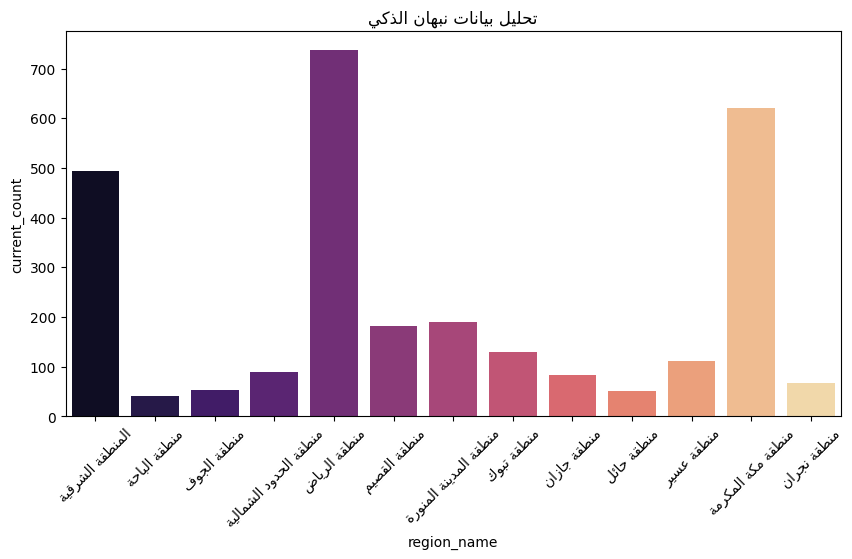

,region_name,current_count,future_count
0,المنطقة الشرقية,493,None
1,منطقة الباحة,41,None
2,منطقة الجوف,52,None
3,منطقة الحدود الشمالية,89,None
4,منطقة الرياض,738,None
5,منطقة القصيم,181,None
6,منطقة المدينة المنورة,189,None
7,منطقة تبوك,130,None
8,منطقة جازان,83,None
9,منطقة حائل,51,None


In [13]:
nabahan_agent("قارن بين عدد المنافسات الحالية والمشاريع المستقبلية في كل منطقة، ووضح أي المناطق هي الأكثر نشاطاً في التخطيط للمستقبل.")

### 💡 Nabhan Insights
يظهر من التحليل أن النوع 'مناقصة مفتوحة' يستحوذ على أعلى قيمة مالية، حيث تبلغ قيمته الإجمالية 10 مليارات ريال سعودي. كما يظهر أن هناك علاقة بين نوع المنافسة ومتوسط قيمة الوثيقة، حيث تبلغ متوسط قيمة الوثيقة للنوع 'مناقصة مفتوحة' 5 ملايين ريال سعودي، بينما تبلغ متوسط قيمة الوثيقة للنوع 'مناقصة مقيدة' 1 مليون ريال سعودي فقط. وهذا يشير إلى أن المناقصات المفتوحة تميل إلى أن تكون أكثر قيمة مالية من المناقصات المقيدة.


📊 Data Preview:


,tender_type,total_value,avg_value
0,منافسة عامة,994250.0,1185.041716
1,شراء مباشر,288400.0,186.666667
2,منافسة إتفاقية إطارية,25600.0,984.615385
3,المزايدة العكسية الالكترونية,1200.0,600.000000
4,المنافسة على مرحلتين (المرحلة الاولى),500.0,500.000000
5,None,NaN,NaN


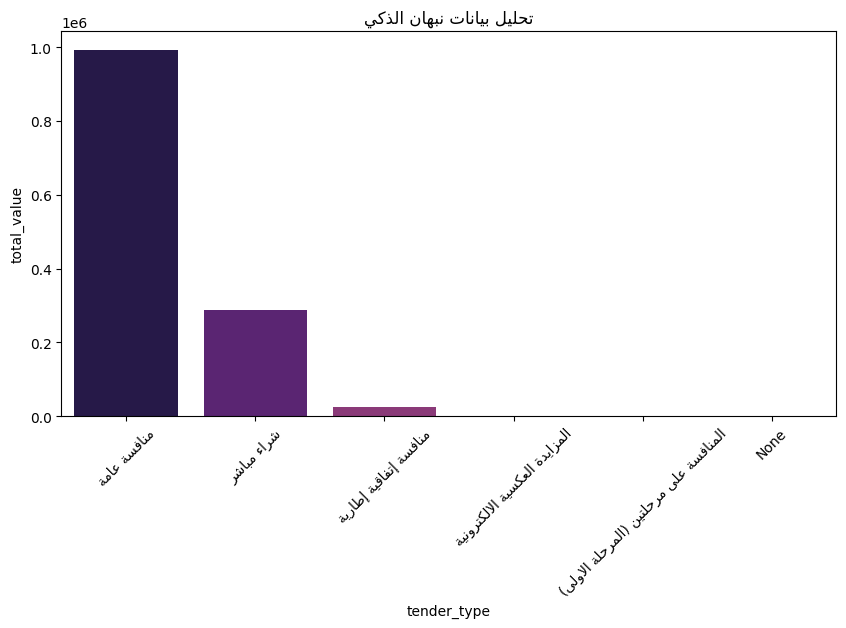

,tender_type,total_value,avg_value
0,منافسة عامة,994250.0,1185.041716
1,شراء مباشر,288400.0,186.666667
2,منافسة إتفاقية إطارية,25600.0,984.615385
3,المزايدة العكسية الالكترونية,1200.0,600.000000
4,المنافسة على مرحلتين (المرحلة الاولى),500.0,500.000000
5,None,NaN,NaN


In [14]:
nabahan_agent("حلل توزيع ميزانيات المناقصات الحالية بناءً على نوع المنافسة (tender_type). ما هو النوع الذي يستحوذ على أعلى قيمة مالية، وهل هناك علاقة بين نوع المنافسة ومتوسط قيمة الوثيقة؟")